# WZE-UAV Image Classification using Deep Learning

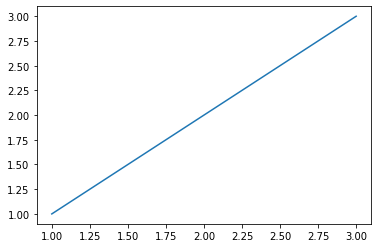

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import mlxtend
from pathlib import Path
from tqdm.auto import tqdm



x = (1,3)
y = (1,3)
plt.plot(x,y)

In [2]:
import torch
import torchvision.transforms as T
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchinfo import summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import h5py

In [3]:
import wze_uav.data_loader as data_loader
import wze_uav.visualization as visualization
import wze_uav.models as models
from wze_uav.engine import *
from wze_uav.utils2 import *
from wze_uav.log_writer import create_writer

#### Get PyTorch version

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


#### Preparing device agnostic code 

In [5]:
# ensure device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# get index of currently selected device
print(f"Index of current divice: {torch.cuda.current_device()}")
# get number of GPUs available
print(f"Number of GPUs available: {torch.cuda.device_count()}")
# get the name of the device
print(f"GPU Model: {torch.cuda.get_device_name(0)}")

cuda
Index of current divice: 0
Number of GPUs available: 1
GPU Model: Quadro RTX 8000


#### Ensure reproducibility 

In [6]:
# for more information, see also: https://pytorch.org/docs/stable/notes/randomness.html

# Set seeds
def set_seeds(seed: int=0):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 0.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# seed for numpy
np.random.seed(0)
# avoiding non-deterministic algorithms
#torch.use_deterministic_algorithms(True)
# Set to true -> might speed up the process but should be set to False if reproducible results are desired
torch.backends.cudnn.benchmark = True


#### Define file directories

In [7]:
set_seeds() # ensure reproducibility

# Data 2020
train_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\train"
val_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\val"
test_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\test"

# Data 2021
train_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\train"
val_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\val"
test_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\test"

# Data 2022
train_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\train"
val_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\val"
test_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\test"



#### Load images and features (labels and tree species) from hdf5 files

In [8]:
# load all image and feature arrays from hdf5
# loops through all hdf5 files! 

# Data 2020
train_image_set_2020, train_label_set_2020, train_species_set_2020, train_kkl_set_2020, train_bk_set_2020 = data_loader.hdf5_to_img_label(train_data_path, load_sets = ["images_masked"])
val_image_set_2020, val_label_set_2020, val_species_set_2020, val_kkl_set_2020, val_bk_set_2020 = data_loader.hdf5_to_img_label(val_data_path, load_sets = ["images_masked"])
test_image_set_2020, test_label_set_2020, test_species_set_2020, test_kkl_set_2020, test_bk_set_2020 = data_loader.hdf5_to_img_label(test_data_path, load_sets = ["images_masked"])

# Data 2021
train_image_set_2021, train_label_set_2021, train_species_set_2021, train_kkl_set_2021, train_bk_set_2021 = data_loader.hdf5_to_img_label(train_data_path_2021, load_sets = ["images_masked"])
val_image_set_2021, val_label_set_2021, val_species_set_2021, val_kkl_set_2021, val_bk_set_2021 = data_loader.hdf5_to_img_label(val_data_path_2021, load_sets = ["images_masked"])
test_image_set_2021, test_label_set_2021, test_species_set_2021, test_kkl_set_2021, test_bk_set_2021 = data_loader.hdf5_to_img_label(test_data_path_2021, load_sets = ["images_masked"])

# Data 2022
train_image_set_2022, train_label_set_2022, train_species_set_2022, train_kkl_set_2022, train_bk_set_2022 = data_loader.hdf5_to_img_label(train_data_path_2022, load_sets = ["images_masked"])
val_image_set_2022, val_label_set_2022, val_species_set_2022, val_kkl_set_2022, val_bk_set_2022 = data_loader.hdf5_to_img_label(val_data_path_2022, load_sets = ["images_masked"])
test_image_set_2022, test_label_set_2022, test_species_set_2022, test_kkl_set_2022, test_bk_set_2022 = data_loader.hdf5_to_img_label(test_data_path_2022, load_sets = ["images_masked"])








In [9]:
# stack all data from 2020, 2021 and 2022 into one dataset
# images
train_image_set = np.concatenate((train_image_set_2020, train_image_set_2021, train_image_set_2022), axis=0)
val_image_set = np.concatenate((val_image_set_2020, val_image_set_2021, val_image_set_2022), axis=0)
test_image_set = np.concatenate((test_image_set_2020, test_image_set_2021, test_image_set_2022), axis=0)

#labels
train_label_set = np.concatenate((train_label_set_2020, train_label_set_2021, train_label_set_2022), axis=0)
val_label_set = np.concatenate((val_label_set_2020, val_label_set_2021, val_label_set_2022), axis=0)
test_label_set = np.concatenate((test_label_set_2020, test_label_set_2021, test_label_set_2022), axis=0)

#species
train_species_set = np.concatenate((train_species_set_2020, train_species_set_2021, train_species_set_2022), axis=0)
val_species_set = np.concatenate((val_species_set_2020, val_species_set_2021, val_species_set_2022), axis=0)
test_species_set = np.concatenate((test_species_set_2020, test_species_set_2021, test_species_set_2022), axis=0)

#kkl
train_kkl_set = np.concatenate((train_kkl_set_2020, train_kkl_set_2021, train_kkl_set_2022), axis=0)
val_kkl_set = np.concatenate((val_kkl_set_2020, val_kkl_set_2021, val_kkl_set_2022), axis=0)
test_kkl_set = np.concatenate((test_kkl_set_2020, test_kkl_set_2021, test_kkl_set_2022), axis=0)

#bk
train_bk_set = np.concatenate((train_bk_set_2020, train_bk_set_2021, train_bk_set_2022), axis=0)
val_bk_set = np.concatenate((val_bk_set_2020, val_bk_set_2021, val_bk_set_2022), axis=0)
test_bk_set = np.concatenate((test_bk_set_2020, test_bk_set_2021, test_bk_set_2022), axis=0)

In [10]:
# checking shapes and amount of samples. Image sample size should be equal to label sample size!
# Images should be of shape (n, H, W, C): n = sample size | H = image height | W = image width | C = number of bands
print("Dataset 2020")
print(f"\nTrain dataset shape: {train_image_set_2020.shape}")
print(f"Train labels shape: {train_label_set_2020.shape}")
print(f"Train species shape: {train_species_set_2020.shape}")
print(f"Train kkl shape: {train_kkl_set_2020.shape}")
print(f"Train bk shape: {train_bk_set_2020.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2020.shape}")
print(f"Validation labels shape: {val_label_set_2020.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2020.shape}")
print(f"Test labels shape: {test_label_set_2020.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2020.shape[0] + val_image_set_2020.shape[0] + test_image_set_2020.shape[0]}")
print(f"Total label samples: {train_label_set_2020.shape[0] + val_label_set_2020.shape[0] + test_label_set_2020.shape[0]}\n")
print("="*50)
print("\nDataset 2021")
print(f"\nTrain dataset shape: {train_image_set_2021.shape}")
print(f"Train labels shape: {train_label_set_2021.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2021.shape}")
print(f"Validation labels shape: {val_label_set_2021.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2021.shape}")
print(f"Test labels shape: {test_label_set_2021.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2021.shape[0] + val_image_set_2021.shape[0] + test_image_set_2021.shape[0]}")
print(f"Total label samples: {train_label_set_2021.shape[0] + val_label_set_2021.shape[0] + test_label_set_2021.shape[0]}\n")
print("="*50)
print("\nDataset 2022")
print(f"\nTrain dataset shape: {train_image_set_2022.shape}")
print(f"Train labels shape: {train_label_set_2022.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2022.shape}")
print(f"Validation labels shape: {val_label_set_2022.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2022.shape}")
print(f"Test labels shape: {test_label_set_2022.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2022.shape[0] + val_image_set_2022.shape[0] + test_image_set_2022.shape[0]}")
print(f"Total label samples: {train_label_set_2022.shape[0] + val_label_set_2022.shape[0] + test_label_set_2022.shape[0]}\n")
print("="*50)
print("\nStacked Dataset")
print(f"\nTrain dataset shape: {train_image_set.shape}")
print(f"Train labels shape: {train_label_set.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set.shape}")
print(f"Validation labels shape: {val_label_set.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set.shape}")
print(f"Test labels shape: {test_label_set.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set.shape[0] + val_image_set.shape[0] + test_image_set.shape[0]}")
print(f"Total label samples: {train_label_set.shape[0] + val_label_set.shape[0] + test_label_set.shape[0]}\n")

Dataset 2020

Train dataset shape: (4886, 250, 250, 3)
Train labels shape: (4886, 1)
Train species shape: (4886, 1)
Train kkl shape: (4886, 1)
Train bk shape: (4886, 1)
--------------------------------------------------
Validation dataset shape: (1053, 250, 250, 3)
Validation labels shape: (1053, 1)
--------------------------------------------------
Test dataset shape: (917, 250, 250, 3)
Test labels shape: (917, 1)
--------------------------------------------------

Total image samples: 6856
Total label samples: 6856


Dataset 2021

Train dataset shape: (4505, 250, 250, 3)
Train labels shape: (4505, 1)
--------------------------------------------------
Validation dataset shape: (1053, 250, 250, 3)
Validation labels shape: (1053, 1)
--------------------------------------------------
Test dataset shape: (877, 250, 250, 3)
Test labels shape: (877, 1)
--------------------------------------------------

Total image samples: 6435
Total label samples: 6435


Dataset 2022

Train dataset shape:

#### Define data transforms and create PyTorch Datasets (converts ndarrays into tensors)

In [11]:
# train transform with augmentation. 
transform_train = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      #                     std=[0.229, 0.224, 0.225]),
                                      #transforms.ColorJitter(brightness=(0.5,1.5), contrast=(0.5,1.2), saturation=(0.5,1.2), hue=(-0.05,0.05)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(degrees=[-90,90]),
                                      #transforms.Resize(224)
                                      ])

# test and val dataset transform without augmentation. 
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Resize(224)
                               ])


# class names need to fit the customDataset class used e.g. 3 classes -> use CustomDataset3Classes
#class_names = ['healthy', 'slightly_stressed', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['healthy', 'moderately_stressed', 'highly_stressed', 'dead']
class_names = ['healthy', 'stressed', 'dead']

# choose custom dataset loader with 3 - 5 classes
train_dataset = data_loader.CustomDataset3Classes(
    data = train_image_set,
    labels = train_label_set,
    class_names=class_names, 
    species = train_species_set,
    kkl = train_kkl_set,
    transform=transform_train
)

val_dataset = data_loader.CustomDataset3Classes(
    data = val_image_set,
    labels = val_label_set,
    class_names=class_names,
    species = val_species_set,
    kkl = val_kkl_set,
    transform=transform
)

test_dataset = data_loader.CustomDataset3Classes(
    data = test_image_set,
    labels = test_label_set,
    class_names=class_names, 
    species = test_species_set,
    kkl = test_kkl_set,
    transform=transform
)



#### Visualize random images from the datasets

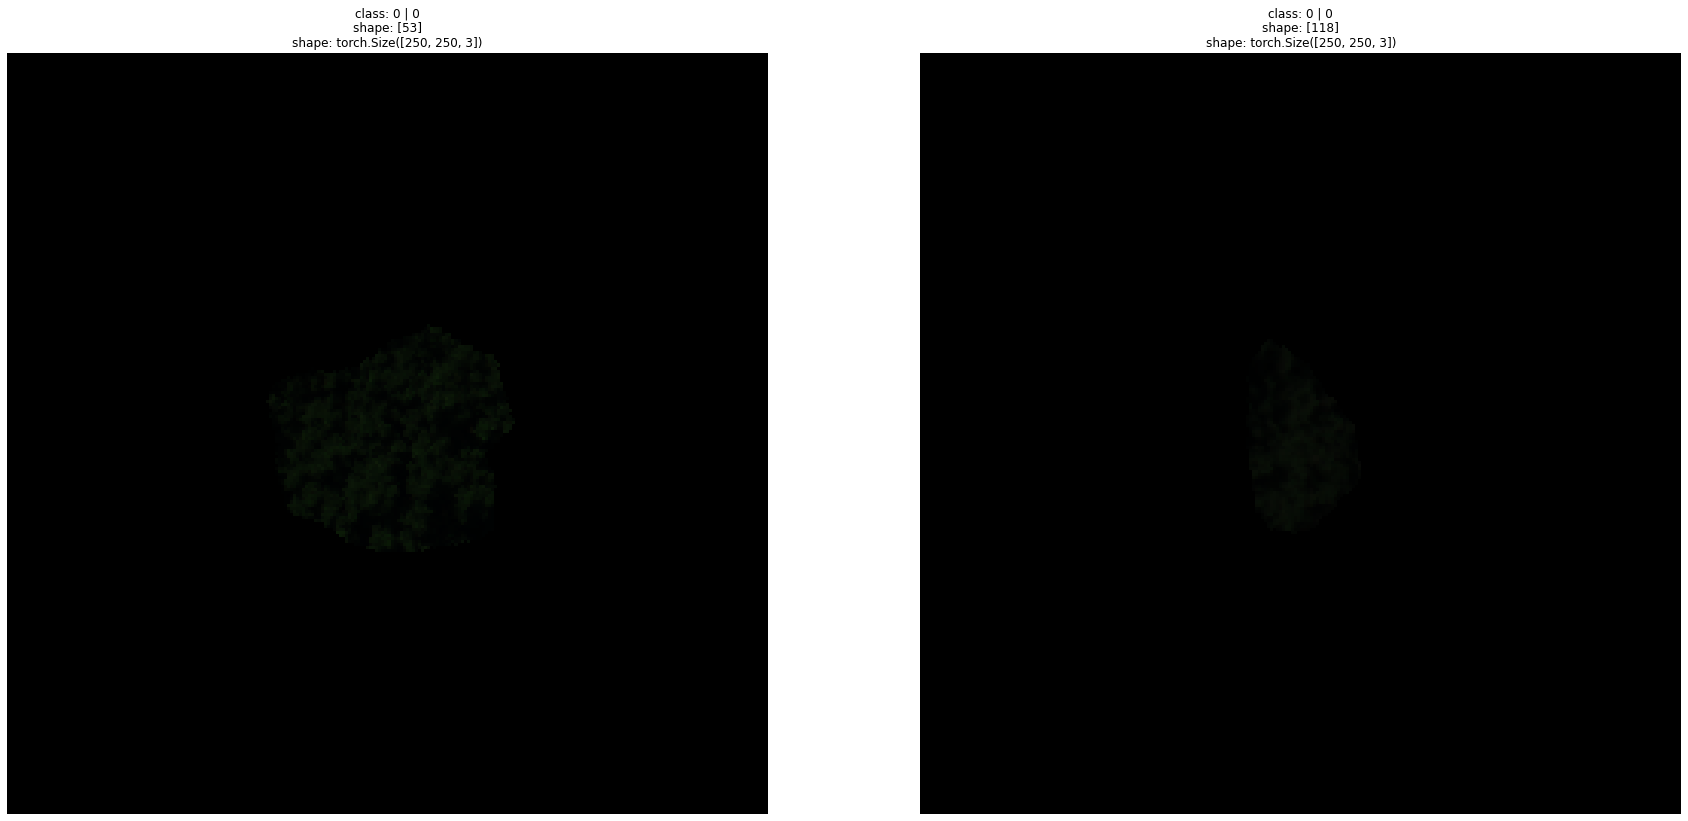

In [12]:
# enhance brightness in colorjitter for better visibility
visualization.display_random_images(train_dataset, 
                      n=2, 
                      classes=[0, 1, 2],
                      seed=None)


#### Check shape and data types of images and labels

In [13]:
img, label = test_dataset[0]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 250, 250])
Image datatype: torch.float32
Image label: 1
Label datatype: <class 'int'>


#### Create PyTorch Dataloaders

In [14]:
# set seeds
g = torch.Generator()
g.manual_seed(0)
NUM_WORKERS=3 # should be changed, depending on the system used
batch_size=32

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              persistent_workers=True,
                              pin_memory=True,
                              num_workers=NUM_WORKERS, 
                              generator=g,
                              shuffle=True,
                              drop_last=False)

val_dataloader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=False)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=False)

print(f"Train dataloader size: {len(train_dataloader)}")
print(f"Val dataloader size: {len(val_dataloader)}")
print(f"Test dataloader size: {len(test_dataloader)}")

Train dataloader size: 420
Val dataloader size: 91
Test dataloader size: 79


#### Create and print model

In [15]:
# Create model
classes = train_dataset.class_names
num_classes = len(classes) # get output_shape (number of classes) as an argument for the model

effnet_b0 = models.create_effnetb0(output_shape=num_classes, dropout_rate=0.3, unfreeze=True, device=device)

[INFO] Created new effnet_b0 model.


In [16]:
# Print out model summary
summary(effnet_b0, 
        input_size=(32, 3, 250, 250), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=17,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Trainable
EfficientNet (EfficientNet)                                  [32, 3, 250, 250] [32, 3]           --                True
├─Sequential (features)                                      [32, 3, 250, 250] [32, 1280, 8, 8]  --                True
│    └─Conv2dNormActivation (0)                              [32, 3, 250, 250] [32, 32, 125, 125] --                True
│    │    └─Conv2d (0)                                       [32, 3, 250, 250] [32, 32, 125, 125] 864               True
│    │    └─BatchNorm2d (1)                                  [32, 32, 125, 125] [32, 32, 125, 125] 64                True
│    │    └─SiLU (2)                                         [32, 32, 125, 125] [32, 32, 125, 125] --                --
│    └─Sequential (1)                                        [32, 32, 125, 125] [32, 16, 125, 125] --                True
│    │    └─MBConv (0)       

#### Set model training parameters (multiple experiments possible)

In [17]:
# 1. Create epochs list
num_epochs = [100]

# 2. Create models list (need to create a new model for each experiment)
models_list = ["effnet_b0", "effnet_b7"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"train_data": train_dataloader}

# 4. Create target folder name were to save the tensorboard event files
target_dir = "log_test"

In [18]:
# 5. set number of samples for each class to consider class imbalance

#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)



#loss_weight = torch.Tensor([3730, 7632, 6578, 553, 312]) # 5 classes
#loss_weight = torch.Tensor([11362, 6578, 553, 312]) # 4 classes


# Loss weight for 3 classes
#loss_weight = torch.Tensor([5.042, 1.274, 60.272]) # 3 classes | 0-10 = healthy, 15-95 = stressed, 99-100 = dead
#loss_weight = torch.Tensor([1.655, 2.637, 60.272]) # 3 classes | 0-25 = healthy, 30-95 = stressed, 99-100 = dead
#loss_weight = torch.Tensor([1.099, 12.732, 60.272]) # 3 classes| 0-45 = healthy, 50-95 = stressed, 99-100 = dead
#num_samples_class = [11362, 7131, 312] # 3 classes| 0-25 = healthy, 30-95 = stressed, 99-100 = dead
#num_samples_class = [16296, 2197, 312] # 3 classes| 0-40 = healthy, 45-95 = stressed, 99-100 = dead
num_samples_class = [17016, 1477, 312] # 3 classes| 0-45 = healthy, 50-95 = stressed, 99-100 = dead

loss_weight = [(1. / num_samples_class[i])*(18805 / 2.0) for i in range(len(num_samples_class))]
loss_weight = torch.Tensor(loss_weight)
print(f"Loss weights: {loss_weight}")
loss_weight = loss_weight.to(device)
# data 2020: [1194, 2516, 2776, 273, 97] (12 = NBV 99)
# data 2021: [1097, 2548, 2475, 203, 112] (2 = NBV 99)
# data 2022: [1439, 2568, 1327, 912, 88] (1 = NBV 99)

Loss weights: tensor([ 0.5526,  6.3659, 30.1362])


In [ ]:
###### define Parameters######
n_bands = 3 # define number of bands
classes = train_dataset.class_names
num_classes = len(classes)
lr = 0.001 # define learning rate
dropout_rate = 0.25 #define dropout rate
unfreeze = True
##############################

#### Start model training

In [ ]:
%%time

# 1. Set the random seeds
set_seeds(seed=0)

# 2. Keep track of experiment numbers
experiment_number = 0

# 4. Loop through each number of epochs
for epochs in num_epochs:
    # 5. Loop through each model name and create a new model based on the name
    for model_name in models_list:
        # 6. Create information print outs
        experiment_number += 1
        print(f"[INFO] Experiment number: {experiment_number}")
        print(f"[INFO] Model: {model_name}")
        print(f"[INFO] Number of epochs: {epochs}")
        # 7. Select the model
        #if model_name == "effnet_b0_custom":
            #model = model.EfficientNet.from_pretrained('efficientnet-b0', in_channels=n_bands, num_classes=num_classes, dropout_rate=0.2)
        #if model_name == "ResNet152_treesat":
        #    treesat_model = r"C:\Users\lwfeckesim\01_PyTorch\TreeSatAI\repo_aligned\trained_models\08_RGB_scheduler_dropout_03_resnet152_treesat_train_data_100_percent_100_epochs.pth"
        #    model = models.create_resnet152(output_shape=num_classes, device=device)
        #    model.fc = nn.Linear(in_features=model.fc.in_features,
        #             out_features=15).to(device)
        #    model.load_state_dict(torch.load(treesat_model))
        #    model.fc = nn.Linear(in_features=model.fc.in_features,
        #             out_features=num_classes).to(device)
            
        #if model_name == "effnet_b0_treesat":
        #    treesat_model = r"C:\Users\lwfeckesim\01_PyTorch\TreeSatAI\repo_aligned\trained_models\06_Effnetb0_RGB_16batch_scheduler_dropout_02_effnet_b0_train_data_100_percent_50_epochs.pth"
        #    model = models.create_effnetb0(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
        #    model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.3, inplace=True),
        #                                           torch.nn.Linear(in_features=1280, # 2048 (b5), 2560 (b7)
        #                                                           out_features=15, # same number of output units as our number of classes
        #                                                           bias=True)).to(device)
        #    model.load_state_dict(torch.load(treesat_model))
        #    model.classifier = torch.nn.Sequential(torch.nn.Dropout(p=0.3, inplace=True),
        #                                           torch.nn.Linear(in_features=1280, # 2048 (b5), 2560 (b7)
        #                                                           out_features=num_classes, # same number of output units as our number of classes
        #                                                           bias=True)).to(device)
        if model_name == "effnet_b0":
            model = models.create_effnetb0(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
        else:
            model = models.create_effnetb7(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
                     
        # 8. Create a new loss and optimizer for every model
        loss_fn = nn.CrossEntropyLoss(weight=loss_weight)  
        optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
        
        
        # 9. Train target model with target dataloaders and track experiments
        results = train(model=model,
                        n_bands=n_bands,
                        batch_size=batch_size,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader, 
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        num_classes=num_classes,
                        epochs=epochs,
                        device=device,
                        writer=create_writer(target_dir=target_dir,
                                             experiment_name='test',
                                             model_name=model_name,
                                             extra=f"{epochs}_epochs"))
        
        # 10. Save the model to file so we can get back the best model
        save_filepath = f"01_{model_name}_{epochs}_epochs.pth"
        save_model(model=model,
                   target_dir="models",
                   model_name=save_filepath)
        print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnet_b0
[INFO] Number of epochs: 100
[INFO] Created new effnet_b0 model.
[INFO] Created SummaryWriter, saving to: log_test\2023-03-24\test\effnet_b0\100_epochs...


  0%|          | 0/100 [00:00<?, ?it/s]

[INFO] Saving model to: models\01_0_epochs.pth
Epoch: 1 
Train loss: 0.8609 | Train precision: 0.8735 | Train recall: 0.6401 | Train f1score: 0.7135 
Val loss: 0.6824 | Val precision: 0.8163 | Val recall: 0.9191 | Val f1score: 0.8533 

[INFO] Saving model to: models\01_1_epochs.pth
Epoch: 2 
Train loss: 0.6917 | Train precision: 0.8931 | Train recall: 0.6791 | Train f1score: 0.7500 
Val loss: 0.8030 | Val precision: 0.8383 | Val recall: 0.9175 | Val f1score: 0.8642 

[INFO] Saving model to: models\01_2_epochs.pth
Epoch: 3 
Train loss: 0.6757 | Train precision: 0.8951 | Train recall: 0.6858 | Train f1score: 0.7571 
Val loss: 0.7006 | Val precision: 0.7720 | Val recall: 0.9302 | Val f1score: 0.8201 

[INFO] Saving model to: models\01_3_epochs.pth
Epoch: 4 
Train loss: 0.6596 | Train precision: 0.8949 | Train recall: 0.6856 | Train f1score: 0.7555 
Val loss: 0.6303 | Val precision: 0.8716 | Val recall: 0.9139 | Val f1score: 0.8856 

[INFO] Saving model to: models\01_4_epochs.pth
Epoch: 5 

In [ ]:
def test_step2(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              num_classes: int,
              device: torch.device) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_precision, test_recall, test_f1_score = 0, 0, 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            #loss_weighted = loss_fn(y_pred, y)
            #test_loss_weighted += loss_weighted.item() 
            
            # Calculate and accumulate evaluation metrics            
            pre_metrics = MulticlassPrecision(num_classes=num_classes, average='weighted').to(device)
            test_precision += pre_metrics(y_pred, y)
            
            rec_metrics = MulticlassRecall(num_classes=num_classes, average='weighted').to(device)
            test_recall += rec_metrics(y_pred, y)
            
            f1_metrics = MulticlassF1Score(num_classes=num_classes, average='weighted').to(device)
            test_f1_score += f1_metrics(y_pred, y)
             
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_precision = test_precision / len(dataloader)
    test_recall = test_recall / len(dataloader)
    test_f1_score = test_f1_score / len(dataloader)
    
   
   
    return test_loss, test_recall, test_precision, test_f1_score

In [ ]:
loss_fn = nn.CrossEntropyLoss(weight=loss_weight)
test_loss, test_recall, test_precision, test_f1_score = test_step2(model=model,
                                                                         dataloader=test_dataloader,
                                                                         loss_fn=loss_fn,
                                                                         num_classes=num_classes,
                                                                         device=device)

In [ ]:
print(f"Test loss: {test_loss}")
print(f"Test recall: {test_recall}")
print(f"Test precision: {test_precision}")
print(f"Test F1score: {test_f1_score}")

In [ ]:
def make_predictions(model: torch.nn.Module, 
                     test_dataloader: torch.utils.data.DataLoader,
                     device: torch.device):
    # 1. Make predictions with trained model
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model(X)
            # Turn predictions from logits -> prediction probabilities -> predictions labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor

In [ ]:
def val_labels_3classes(test_dataset: torch.utils.data.dataset.Dataset):
    torch_tensor = test_dataset.labels
    torch_tensor = torch_tensor.squeeze(dim=1)
    np_arr = torch_tensor.cpu().detach().numpy()
    label_list = []
    for i in np_arr:
        if i <= 45:
            label = 0
            label_list.append(label)
        elif i > 45 and i <= 95:
            label = 1
            label_list.append(label)
        else:
            label = 2
            label_list.append(label)
    array_labels = np.array(label_list)
    val_labels = torch.from_numpy(array_labels)
    return val_labels

In [ ]:
# 2. Setup confusion matrix instance and compare predictions to targets
#from wze_uav.analysis import *
y_pred_tensor = make_predictions(model=model,
                                 test_dataloader=test_dataloader, 
                                 device=device)

val_labels = val_labels_3classes(test_dataset=test_dataset)

confmat = ConfusionMatrix(num_classes=num_classes, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=val_labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [ ]:
# Setup the best model filepath
best_model_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\models\01_effnet_b0_train_data_100_percent_5_epochs.pth"

# Instantiate a new instance of EffNetB0 (to load the saved state_dict() to)
unfreeze=True
best_model = models.create_effnetb0(output_shape=num_classes, unfreeze=unfreeze, device=device)

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))